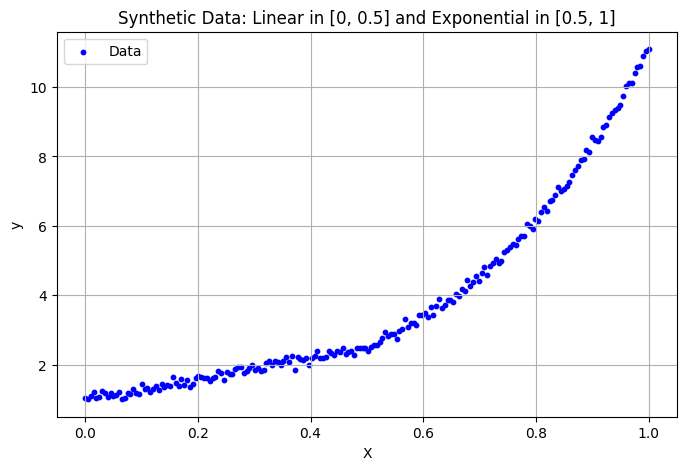

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set a seed for reproducibility
np.random.seed(42)

# Generate X values between 0 and 1
X = np.linspace(0, 1, 200)

# Define the behavior of y
y = np.zeros_like(X)

# Y is linear in the range [0, 0.5]
linear_range = (X <= 0.5)
y[linear_range] = 3 * X[linear_range] + 1  # Linear: Y = 3X + 1

# Get the value of y at X = 0.5 to ensure continuity
y_at_05 = 3 * 0.5 + 1  # y(0.5) = 3(0.5) + 1 = 2.5

# y is exponential in the range [0.5, 1], starting from y_at_05
exponential_range = (X > 0.5)
y[exponential_range] = y_at_05 * np.exp(3 * (X[exponential_range] - 0.5))  # Adjusted exponential to start from Y(0.5)

# Add some noise to make it more realistic
noise = np.random.normal(0, 0.1, X.shape)
y += noise

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the synthetic data
plt.figure(figsize=(8, 5))
plt.scatter(X, y, label='Data', color='b', s=10)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Data: Linear in [0, 0.5] and Exponential in [0.5, 1]')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build single expert model
def build_single_expert_model():
    model = models.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train single expert model
single_expert_model = build_single_expert_model()
history_single = single_expert_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate on test data
test_loss_single = single_expert_model.evaluate(X_test, y_test, verbose=0)
print(f"Single Expert Model Test Loss: {test_loss_single}")

Single Expert Model Test Loss: 0.3995508551597595


In [5]:
def expert_model(input_dim, output_dim, hidden_units):
    return models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dense(output_dim)
    ])

def gate_model(input_dim, num_experts):
    return models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_experts, activation='softmax')  # Outputs a probability distribution over experts
    ])

In [6]:
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, output_dim, num_experts, expert_hidden_units, gate_hidden_units):
        super(MixtureOfExperts, self).__init__()
        self.experts = [expert_model(input_dim, output_dim, expert_hidden_units) for _ in range(num_experts)]
        self.gate = gate_model(input_dim, num_experts)
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]
        gate_output = self.gate(inputs)
        weighted_expert_outputs = [tf.multiply(expert_output, tf.expand_dims(gate_output[:, i], axis=1))
                                   for i, expert_output in enumerate(expert_outputs)]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        final_output = self.output_layer(aggregated_output)
        return final_output

# Build and train the Mixture of Experts model
num_experts = 3
moe_model = MixtureOfExperts(input_dim=1, output_dim=1, num_experts=num_experts, expert_hidden_units=64, gate_hidden_units=64)
moe_model.compile(optimizer='adam', loss='mse')

history_moe = moe_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluate on test data
test_loss_moe = moe_model.evaluate(X_test, y_test, verbose=0)
print(f"Mixture of Experts Model Test Loss: {test_loss_moe}")

Mixture of Experts Model Test Loss: 0.025273894891142845


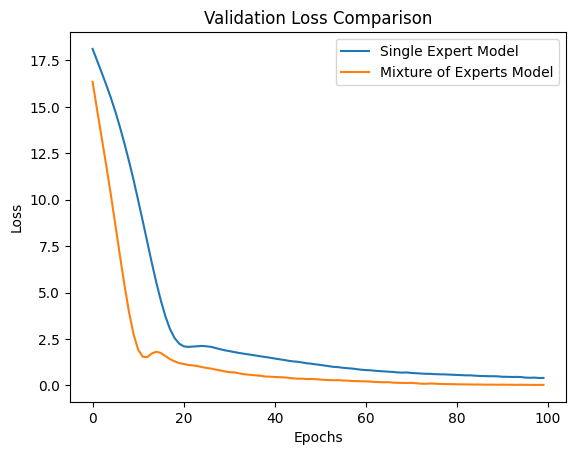

In [7]:
plt.plot(history_single.history['val_loss'], label='Single Expert Model')
plt.plot(history_moe.history['val_loss'], label='Mixture of Experts Model')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


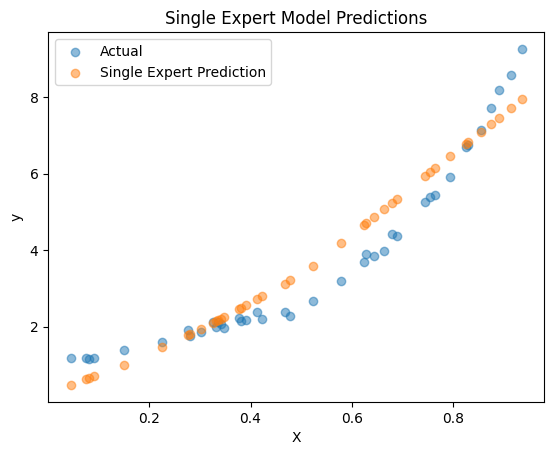

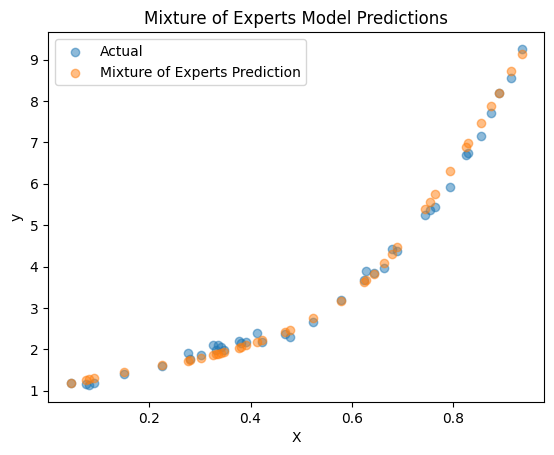

In [8]:
# Generate predictions
y_pred_single = single_expert_model.predict(X_test)
y_pred_moe = moe_model.predict(X_test)

# Plot actual vs predicted for single expert model
plt.scatter(X_test, y_test, label='Actual', alpha=0.5)
plt.scatter(X_test, y_pred_single, label='Single Expert Prediction', alpha=0.5)
plt.title('Single Expert Model Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# Plot actual vs predicted for Mixture of Experts model
plt.scatter(X_test, y_test, label='Actual', alpha=0.5)
plt.scatter(X_test, y_pred_moe, label='Mixture of Experts Prediction', alpha=0.5)
plt.title('Mixture of Experts Model Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error
# Root Mean Squared Error (RMSE)
rmse_single = np.sqrt(mean_squared_error(y_test, y_pred_single))
rmse_moe = np.sqrt(mean_squared_error(y_test, y_pred_moe))

print(f"Single Expert Model RMSE: {rmse_single}")
print(f"Mixture of Experts Model RMSE: {rmse_moe}")

Single Expert Model RMSE: 0.6321003947170614
Mixture of Experts Model RMSE: 0.15897764670140593
